In [80]:
import jax
import jax.numpy as jnp
import scipy

# Calculate the hamiltonian of a spring oscillator 
def hamiltonian(coords: jnp.array):
    q, p = coords[0], coords[1]
    H = q**2 + p**2
    return H

def dynamics(t, coords: jnp.array):
    H_grad = jax.grad(hamiltonian)(coords)
    dH_dq, dH_dp = H_grad[0], H_grad[1]
    return jnp.array([dH_dp, -dH_dq])

def run_trajectory(rng_key, t_start=0, t_end=3, steps_per_second=10, radius=None, init_coords=None, noise_std=0.1):
    t_eval = jnp.linspace(t_start, t_end, int((t_end - t_start) * steps_per_second))

    # Start at random position
    if init_coords is None:
        rng_key, subkey = jax.random.split(rng_key)
        init_coords = jax.random.uniform(subkey, (2,)) * 2 - 1

    if radius is None:
        rng_key, subkey = jax.random.split(rng_key)
        radius = jax.random.uniform(subkey) * 0.9 + 0.1
    init_coords = init_coords / jnp.sqrt(jnp.sum(init_coords**2)) * radius

    # Solve integral numerically
    spring_ivp = scipy.integrate.solve_ivp(dynamics, t_span=[t_start, t_end], y0=init_coords, t_eval=t_eval, rtol=1e-10)

    # Get coordinates and calculate gradients required for training
    coords = spring_ivp['y'].T
    H_gradients = jax.vmap(dynamics, in_axes=(None, 0))(None, coords)

    # Add noise to coords to make data more "realistic"
    coords += jax.random.normal(rng_key, coords.shape) * noise_std

    return coords, H_gradients

def dynamics_field(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, gridsize=20):
    x, y, = jnp.meshgrid(jnp.linspace(xmin, xmax, gridsize), jnp.linspace(ymin, ymax, gridsize))

    coords = jnp.stack([x.flatten(), y.flatten()]).T
    H_gradients = jax.vmap(dynamics, in_axes=(None, 0))(None, coords)

    field = {
        "coords": coords,
        "H_gradients": H_gradients,
    }

    return field


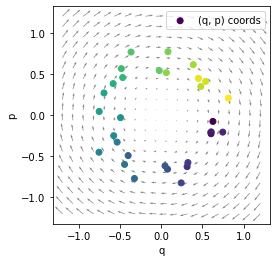

In [81]:
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(42)
coords, _ = run_trajectory(key, radius=0.7, init_coords=jnp.array([1, 0]))

field = dynamics_field(gridsize=20)

plt.quiver(field["coords"][:, 0], field["coords"][:, 1], field["H_gradients"][:, 0], field["H_gradients"][:, 1], color=(.5, .5, .5))
plt.scatter(coords[:, 0], coords[:, 1], c=range(len(coords)), label="(q, p) coords")
plt.xlabel("q")
plt.ylabel("p")
plt.axis('square')
plt.legend()


In [82]:
def create_dataset(seed=42, trajectories=50, test_split=0.5):
    key = jax.random.PRNGKey(seed)

    # Run trajectories
    all_coords = []
    all_H_gradients = []
    for _ in range(trajectories):
        key, subkey = jax.random.split(key)
        coords, H_gradients = run_trajectory(subkey)
        all_coords.append(coords)
        all_H_gradients.append(H_gradients)

    all_coords = jnp.concatenate(all_coords)
    all_H_gradients = jnp.concatenate(all_H_gradients)

    # Split into training and testing data
    n_train = int(len(all_coords) * (1 - test_split))

    data = {}
    data['coords_train'] = all_coords[:n_train]
    data['H_gradients_train'] = all_H_gradients[:n_train]
    data['coords_test'] = all_coords[n_train:]
    data['H_gradients_test'] = all_H_gradients[n_train:]

    return data

In [83]:
dataset = create_dataset(trajectories=50)

In [85]:
import haiku as hk
import optax

# Create MLP
def baseline_mlp_fun(x: jnp.array) -> jnp.array:
    mlp = hk.Sequential([
        hk.Linear(200), jax.nn.tanh,
        hk.Linear(200), jax.nn.tanh,
        hk.Linear(200), jax.nn.tanh,
        hk.Linear(2)
    ])

    return mlp(x)

# The baseline model uses a standard L2 supervised loss and directly predicts the gradients
def baseline_loss(params: hk.Params, coords: jnp.array, H_gradients: jnp.array) -> float:
    H_gradients_pred = baseline_net.apply(params, coords)
    loss = jnp.mean((H_gradients_pred[:, 0] - H_gradients[:, 0])**2 + (H_gradients_pred[:, 1] - H_gradients[:, 1])**2)
    return loss

@jax.jit
def baseline_update(params: hk.Params, opt_state: optax.OptState, coords: jnp.array, H_gradients: jnp.array):
    loss, grads = jax.value_and_grad(baseline_loss)(params, coords, H_gradients)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

baseline_net = hk.without_apply_rng(hk.transform(baseline_mlp_fun))
opt = optax.adam(1e-4)

params = baseline_net.init(jax.random.PRNGKey(42), dataset['coords_train'][0])
opt_state = opt.init(params)

for i in range(2000):
    params, opt_state, train_loss = baseline_update(params, opt_state, dataset['coords_train'], dataset['H_gradients_train'])

    if i % 250 == 0:
        print(f"Step: {i}: loss: {train_loss}")

Step: 0: loss: 1.5776762962341309
Step: 250: loss: 0.07743781805038452
Step: 500: loss: 0.07365208119153976
Step: 750: loss: 0.07220190018415451
Step: 1000: loss: 0.07172369956970215
Step: 1250: loss: 0.07149935513734818
Step: 1500: loss: 0.07130594551563263
Step: 1750: loss: 0.07112353295087814


(-6.070001864433289, 4.81327702999115, -5.008077681064606, 5.8752012133598335)

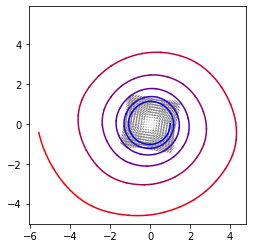

In [87]:
def get_baseline_field(params: hk.Params):
    field = dynamics_field(gridsize=20)
    
    coords = field['coords']
    field['H_gradients'] = baseline_net.apply(params, coords)
    return field


def integrate_baseline_model(params: hk.Params, init_coords, t_start=0, t_end=3, steps_per_second=10):
    def H_gradients_baseline(_, coord):
        H_gradients_pred = baseline_net.apply(params, coord)
        return H_gradients_pred

    t_eval = jnp.linspace(t_start, t_end, int(steps_per_second * (t_end - t_start)))
    spring_ivp = scipy.integrate.solve_ivp(H_gradients_baseline, t_span=[t_start, t_end], y0=init_coords, t_eval=t_eval, rtol=1e-12)
    return spring_ivp['y'].T


init_coords = jnp.array([1, 0])
coords = integrate_baseline_model(params, init_coords, t_start=0, t_end=30, steps_per_second=2000)
field = get_baseline_field(params)

plt.quiver(field["coords"][:, 0], field["coords"][:, 1], field["H_gradients"][:, 0], field["H_gradients"][:, 1], color=(.5, .5, .5))
for i, coord in enumerate(jnp.split(coords, 100)):
    color = (i / 100, 0, 1 - i / 100)
    plt.plot(coord[:, 0], coord[:, 1], color=color)
plt.axis('square')

In [92]:
def hamiltonian_mlp_fun(x: jnp.array) -> jnp.array:
    mlp = hk.Sequential([
        hk.Linear(200), jax.nn.tanh,
        hk.Linear(200), jax.nn.tanh,
        hk.Linear(200), jax.nn.tanh,
        hk.Linear(1)
    ])

    return mlp(x)

def hamiltonian_loss(params: hk.Params, coords: jnp.array, H_gradients: jnp.array) -> float:
    H = lambda x: hamiltonian_net.apply(params, x)[0]

    H_gradients_pred = jax.vmap(jax.grad(H))(coords)
    loss = jnp.mean((-H_gradients_pred[:, 0] - H_gradients[:, 1])**2 + (H_gradients_pred[:, 1] - H_gradients[:, 0])**2)
    return loss

@jax.jit
def hamiltonian_update(params: hk.Params, opt_state: optax.OptState, coords: jnp.array, H_gradients: jnp.array):
    loss, grads = jax.value_and_grad(hamiltonian_loss)(params, coords, H_gradients)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss
   

hamiltonian_net = hk.without_apply_rng(hk.transform(hamiltonian_mlp_fun))
opt = optax.adam(1e-4)

params = hamiltonian_net.init(jax.random.PRNGKey(42), dataset['coords_train'][0])
opt_state = opt.init(params)

for i in range(2000):
    params, opt_state, train_loss = hamiltonian_update(params, opt_state, dataset['coords_train'], dataset['H_gradients_train'])

    if i % 250 == 0:
        print(f"Step: {i}: loss: {train_loss}")

Step: 0: loss: 1.7714781761169434
Step: 250: loss: 0.20788812637329102
Step: 500: loss: 0.08965526521205902
Step: 750: loss: 0.07473308593034744
Step: 1000: loss: 0.07221890985965729
Step: 1250: loss: 0.0720510259270668
Step: 1500: loss: 0.07212565839290619
Step: 1750: loss: 0.07181183993816376


(-1.3200000524520874,
 1.3200000524520874,
 -1.3200000524520874,
 1.3200000524520874)

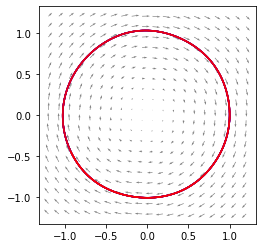

In [100]:
def get_hamiltonian_field(params: hk.Params):
    field = dynamics_field(gridsize=20)

    H = lambda x: hamiltonian_net.apply(params, x)[0]
    
    coords = field['coords']
    H_gradients = jax.vmap(jax.grad(H))(coords)
    field['H_gradients'] = jnp.stack([H_gradients[:, 1], -H_gradients[:, 0]]).T
    return field


def integrate_hamiltonian_model(params: hk.Params, init_coords, t_start=0, t_end=3, steps_per_second=10):
    def H_gradients_hamiltonian(_, coord):
        H = lambda x: hamiltonian_net.apply(params, x)[0]

        H_gradients_pred = jax.grad(H)(coord)
        return jnp.array([H_gradients_pred[1], -H_gradients_pred[0]])

    t_eval = jnp.linspace(t_start, t_end, int(steps_per_second * (t_end - t_start)))
    spring_ivp = scipy.integrate.solve_ivp(H_gradients_hamiltonian, t_span=[t_start, t_end], y0=init_coords, t_eval=t_eval, rtol=1e-12)
    return spring_ivp['y'].T


init_coords = jnp.array([1, 0])
coords = integrate_hamiltonian_model(params, init_coords, t_start=0, t_end=30, steps_per_second=2000)
field = get_hamiltonian_field(params)

plt.quiver(field["coords"][:, 0], field["coords"][:, 1], field["H_gradients"][:, 0], field["H_gradients"][:, 1], color=(.5, .5, .5))

for i, coord in enumerate(jnp.split(coords, 100)):
    color = (i / 100, 0, 1 - i / 100)
    plt.plot(coord[:, 0], coord[:, 1], color=color)
plt.axis('square')